## **PROJECT CONTEXT**

This entire project was conducted on the Databricks Free Edition, a collaborative cloud-based platform designed for large-scale data analysis and machine learning experimentation. While Databricks offers a powerful environment for Spark processing and Python-based machine learning workflows, the Free Edition comes with limited computational resources. To overcome these constraints, we employed a sample size of the dataset as a strategic workaround. This approach allowed us to balance model performance with manageable training times, ensuring that advanced text classification and data-driven analysis of Wikipedia content could still be effectively performed within the lightweight, open-access environment.

Despite the resource limitations, the free-tier setup enabled seamless execution of data exploration, model training, and insight generation, demonstrating that even with restricted computational power, it is possible to conduct meaningful analysis and develop robust machine learning models.

In [ ]:
%sql
-- # 0. DATA LOADING
-- # Create a catalog if it does not exist
CREATE CATALOG IF NOT EXISTS my_catalog;

-- # Create a schema within the catalog if it does not exist
CREATE SCHEMA IF NOT EXISTS my_catalog.raw;

-- # Create a volume (storage location) for datasets if it does not exist
CREATE VOLUME IF NOT EXISTS my_catalog.raw.datasets;

This SQL block prepares the storage and organizational structure in Databricks before loading data:

- It first creates a catalog (my_catalog), which is the top-level container for data objects;
- Inside that catalog, it creates a schema (raw), which organizes tables and views;
- Finally, it creates a volume (datasets) inside the schema, which is a managed storage location for raw files like CSVs.

All statements use IF NOT EXISTS, so running the code multiple times is safe and won’t cause errors if the objects already exist. This step ensures you have a clean, consistent location to store and access the dataset in later stages.

In [ ]:
%sh
# Create the directory path for storing datasets if it does not exist
mkdir -p /Volumes/my_catalog/raw/datasets

# Download the Wikipedia CSV dataset from the given URL and save it to the datasets directory
curl -L "https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv" \
  -o /Volumes/my_catalog/raw/datasets/wikipedia.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  956M  100  956M    0     0  27.2M      0  0:00:35  0:00:35 --:--:-- 29.4M


This shell block prepares the local storage path inside Databricks and downloads the dataset file:

- mkdir -p /Volumes/my_catalog/raw/datasets ensures the directory exists where the dataset will be stored. The -p flag creates all necessary parent directories without error if they already exist;
- curl -L "..." -o /Volumes/my_catalog/raw/datasets/wikipedia.csv downloads the Wikipedia CSV file from the given S3 link and saves it into that directory. The -L option follows redirects to ensure the file is fetched correctly.

This code makes sure there is a proper folder for your raw data and then places the dataset there so it can be loaded into Spark later.

In [ ]:
# Define the path to the downloaded Wikipedia CSV file
path = "/Volumes/my_catalog/raw/datasets/wikipedia.csv"

# Read the CSV file into a Spark DataFrame with header and automatic schema inference
df = spark.read.csv(path, header=True, inferSchema=True)

# Print the schema of the DataFrame to verify column names and types
df.printSchema()

# Display the first 5 rows of the DataFrame for a quick preview
df.show(5, truncate=80)

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- categoria: string (nullable = true)

+---+---------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|_c0|                      title|                                                                         summary|                                                                       documents|                                                                       categoria|
+---+---------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+---------------------------------------------------

This Python block loads the dataset into Spark and quickly inspects it:

- path = "/Volumes/my_catalog/raw/datasets/wikipedia.csv" defines the exact location of the file you just downloaded;
- spark.read.csv(..., header=True, inferSchema=True) reads the CSV into a Spark DataFrame, treating the first row as column headers and automatically inferring data types;
- df.printSchema() prints the structure of the DataFrame, showing column names and their inferred types;
- df.show(5, truncate=80) displays the first 5 rows for a quick preview, truncating long text fields to 80 characters for readability.

This code connects your raw CSV file to Spark, turning it into a structured DataFrame you can analyze.

In [ ]:
# Rename columns for clarity and consistency
df = (df
    .withColumnRenamed("_c0", "id")              # Rename default CSV index column to 'id'
    .withColumnRenamed("title", "title")         # Ensure 'title' column is correctly named
    .withColumnRenamed("summary", "summary")     # Ensure 'summary' column is correctly named
    .withColumnRenamed("documents", "documents") # Ensure 'documents' column is correctly named
    .withColumnRenamed("categoria", "category")  # Rename 'categoria' to 'category' for consistency
)

# Print schema to verify the new column names
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- category: string (nullable = true)



This Python block standardizes and cleans up the column names in your Spark DataFrame:

- It renames the generic _c0 column (created during CSV import) to id, making it a clear unique identifier;
- It keeps title, summary, and documents explicitly named to avoid ambiguity;
- It renames the Italian column categoria into category, ensuring consistent English naming across the project;
- Finally, df.printSchema() checks and confirms that the DataFrame now has the correct, clean column structure.

This step makes the dataset easier to read, consistent, and ready for analysis or machine learning.

In [ ]:
# Print the list of column names to verify renaming
print(df.columns)

['id', 'title', 'summary', 'documents', 'category']


This Python line is a quick verification step:

- print(df.columns) outputs the list of all column names in the DataFrame;
- It’s used right after renaming to confirm that the changes (like converting categoria → category) were applied correctly.

This command double-checks that your DataFrame’s schema matches what you expect before moving forward with analysis.

In [ ]:
# Save the DataFrame as a Delta table in the specified catalog and schema
# Overwrite any existing table and schema to ensure the latest data is used
df.write.format("delta") \
  .mode("overwrite") \
  .option("overwriteSchema", "true") \
  .saveAsTable("my_catalog.raw.Wikipedia")

This Python block saves your cleaned DataFrame as a managed Delta table in Databricks:

- df.write.format("delta") writes the data in the Delta Lake format, which supports ACID transactions, time travel, and efficient queries;
- .mode("overwrite") replaces any existing table with the same name;
- .option("overwriteSchema", "true") ensures the table schema is updated to match the current DataFrame structure;
- .saveAsTable("my_catalog.raw.Wikipedia") registers the table in the Unity Catalog under my_catalog.raw, with the name Wikipedia.

This step persists your DataFrame as a Delta table so it can be queried later with SQL or Spark, ensuring your work is reusable across sessions.

In [ ]:
%sql
-- Count the number of articles per category in the Delta table
-- Group by category and order by the number of articles in descending order
select category,
       count(*) as num_articles
from my_catalog.raw.Wikipedia
group by category
order by num_articles desc;

category num_articles sports 7734 pets 7335 transport 7099 energy 7039 trade 6097 engineering 6014 culture 5646 research 4777 medicine 4489 politics 4082 technology 3521 science 3463 economics 3195 finance 2998 humanities 2729 one nation rallied against liberal government immigration and multicultural policies which 508 such as indigenous land rights and welcome to country ceremonies. hansonism believes that such rights for minority groups 508 chief moli duru ambrae 507 latham commented in 2002: i'm a hater. part of the tribalness of politics is to really dislike the other side with intensity. and the more i see of them the more i hate them. i hate their negativity. i hate their narrowness. i hate the way 506 sitting instead as an independent until june 2018 506 later attending coorparoo state school in coorparoo until she ended her education at age 15 506 edward peate ""ted"" oldfield was a member of the western australian legislative assembly from 1951 to 1965 253 he was nominated for ""choice tv breakout performance – male"" at the 2005 teen choice awards and ""outstanding performance by an ensemble in a drama series"" at the 2008 screen actors guild awards. he received a ""golden boomerang"" at the 2006 australians in film breakthrough awards for his work on house. in 2007 253 she had three children aged 7 253 in which the then nsw minister for education 253 when mal washer regained the seat for the liberals. after leaving politics 253 and therefore any candidates which that party chose to stand at state elections could not use the party name. this resulted in the unusual situation of having two parties named “one nation”; the official party could contest federal elections in nsw under the ""one nation"" banner as it held that name with the federal electoral authorities 253 georgiou's brother-in-law. culleton was declared to have been elected to the senate when the writs were returned. however 253 and there were concerns that hill's dual citizenship could contravene this provision. on 19 november she contacted the high commission of the united kingdom in brisbane 253 he is a drag queen whose taste in fashion parodies hanson's 253 stating: it seems that every group pride is promoted in the media and schools except for ours 253 304. in 2014 culleton was bankrupted over this debt 253 mihailuk announced that she would be running second on the one nation ticket at the upcoming 2023 new south wales state election for the legislative council 253 sampled from interviews and media clips. it peaked at number 10 on the australian aria charts and was ranked number 58 in the 1998 triple j hottest 100 countdown." 253 van lieshout was convicted for breaching planning laws after putting up political signage outside her home during an election. she had two appeals rejected by the supreme court of western australia.on 8 september 2015 253 and that's what broinowski’s documentary does so well: it illuminates a hare-brained and bizarre woman 253 and do not reflect the views of the montessori foundation or the international montessori council"". earlier climate-change denial activities from 2006 until his election to the senate 253 based on knowledge only cringer would have 198 dollink""). some sources 125 swift wind has a sardonic tongue and pursues his own political agenda of liberating etheria's horses. spirit / swift wind are voiced by lou scheimer in the 1980s series and by adam ray in the 2018 series. bow bow is an archer who is one of the original rebels. bow often has to disguise himself when leaving the whispering woods 114 but see the rfc before doing mass systematic removals. this message is updated dynamically through the template {{source check}} (last update: 18 january 2022). if you have discovered urls which were erroneously considered dead by the bot 108 shorts 96 however 86 if we are not proud of having our own language and script"". the event showed that the knowledge of one's mother language is of the top importance in comp

This SQL block performs a simple descriptive analysis on the saved Delta table:

- It queries the table my_catalog.raw.Wikipedia;
- 'count(*) as num_articles' calculates how many rows (articles) belong to each category;
- 'group by category' groups the results by article category;
- 'order by num_articles desc' sorts the output so the categories with the most articles appear first.

This query gives you a ranked summary of how many articles exist per category, which is the first step in the exploratory analysis.

In [ ]:
# 1. DESCRIPTIVE CONTENT ANALYSIS
# Install package
%pip install wordcloud

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [ ]:
# Load all project packages
from pyspark.sql import functions as F
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="Exception ignored on calling ctypes callback")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff251f21afc0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [ ]:
# Count the number of articles per category
# Aggregate by 'category' and count the number of rows per group
df_counts = df.groupBy("category").agg(F.count("*").alias("num_articles"))

# Convert the Spark DataFrame to Pandas for easier plotting or display
counts_pdf = df_counts.orderBy(F.desc("num_articles")).toPandas()

# Display the resulting Pandas DataFrame
display(counts_pdf)

category num_articles sports 7734 pets 7335 transport 7099 energy 7039 trade 6097 engineering 6014 culture 5646 research 4777 medicine 4489 politics 4082 technology 3521 science 3463 economics 3195 finance 2998 humanities 2729 such as indigenous land rights and welcome to country ceremonies. hansonism believes that such rights for minority groups 508 one nation rallied against liberal government immigration and multicultural policies which 508 chief moli duru ambrae 507 later attending coorparoo state school in coorparoo until she ended her education at age 15 506 sitting instead as an independent until june 2018 506 latham commented in 2002: i'm a hater. part of the tribalness of politics is to really dislike the other side with intensity. and the more i see of them the more i hate them. i hate their negativity. i hate their narrowness. i hate the way 506 sampled from interviews and media clips. it peaked at number 10 on the australian aria charts and was ranked number 58 in the 1998 triple j hottest 100 countdown." 253 she had three children aged 7 253 and therefore any candidates which that party chose to stand at state elections could not use the party name. this resulted in the unusual situation of having two parties named “one nation”; the official party could contest federal elections in nsw under the ""one nation"" banner as it held that name with the federal electoral authorities 253 304. in 2014 culleton was bankrupted over this debt 253 mihailuk announced that she would be running second on the one nation ticket at the upcoming 2023 new south wales state election for the legislative council 253 van lieshout was convicted for breaching planning laws after putting up political signage outside her home during an election. she had two appeals rejected by the supreme court of western australia.on 8 september 2015 253 stating: it seems that every group pride is promoted in the media and schools except for ours 253 and do not reflect the views of the montessori foundation or the international montessori council"". earlier climate-change denial activities from 2006 until his election to the senate 253 georgiou's brother-in-law. culleton was declared to have been elected to the senate when the writs were returned. however 253 and there were concerns that hill's dual citizenship could contravene this provision. on 19 november she contacted the high commission of the united kingdom in brisbane 253 he was nominated for ""choice tv breakout performance – male"" at the 2005 teen choice awards and ""outstanding performance by an ensemble in a drama series"" at the 2008 screen actors guild awards. he received a ""golden boomerang"" at the 2006 australians in film breakthrough awards for his work on house. in 2007 253 edward peate ""ted"" oldfield was a member of the western australian legislative assembly from 1951 to 1965 253 he is a drag queen whose taste in fashion parodies hanson's 253 when mal washer regained the seat for the liberals. after leaving politics 253 and that's what broinowski’s documentary does so well: it illuminates a hare-brained and bizarre woman 253 in which the then nsw minister for education 253 based on knowledge only cringer would have 198 dollink""). some sources 125 swift wind has a sardonic tongue and pursues his own political agenda of liberating etheria's horses. spirit / swift wind are voiced by lou scheimer in the 1980s series and by adam ray in the 2018 series. bow bow is an archer who is one of the original rebels. bow often has to disguise himself when leaving the whispering woods 114 but see the rfc before doing mass systematic removals. this message is updated dynamically through the template {{source check}} (last update: 18 january 2022). if you have discovered urls which were erroneously considered dead by the bot 108 shorts 96 however 86 if we are not proud of having our own language and script"". the event showed that the knowledge of one's mother language is of the top importance in comp

This Python block calculates and visualizes article counts per category:

- df.groupBy("category").agg(F.count("*").alias("num_articles")) groups the data by category and counts how many articles are in each one;
- .orderBy(F.desc("num_articles")) sorts the categories so the ones with the most articles appear first;
- .toPandas() converts the Spark DataFrame into a Pandas DataFrame, which is easier to use for plotting or quick inspection;
- display(counts_pdf) shows the results in a nice tabular format directly in the Databricks notebook.

This code produces a sorted table of article counts per category, ready for visualization or further analysis.

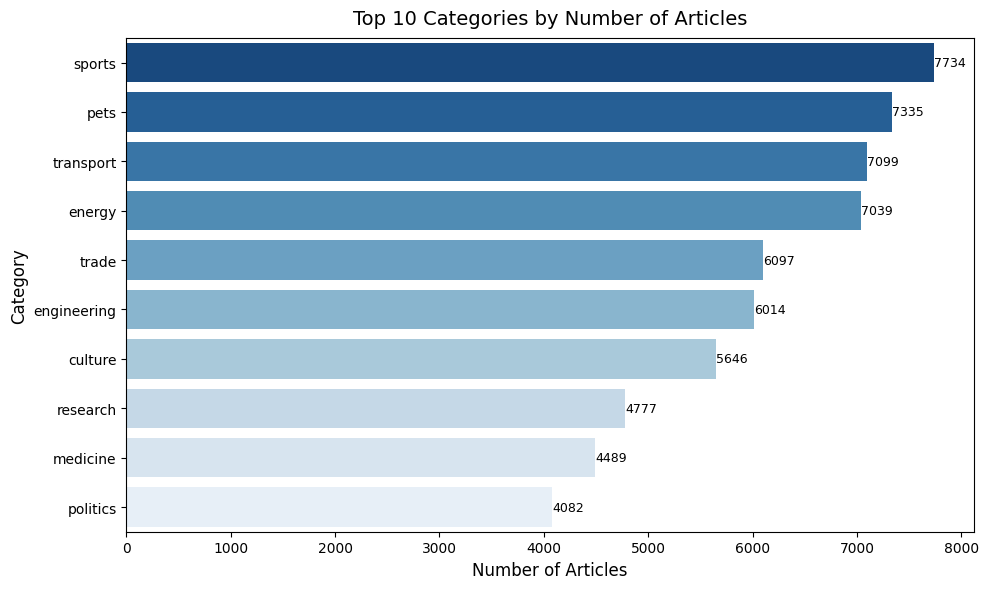

In [ ]:
# Plot the top 10 categories by article count
plt.figure(figsize=(10, 6))
sns.barplot(
    data=counts_pdf.head(10),
    x="num_articles",
    y="category",
    hue="category",
    dodge=False,
    palette="Blues_r",
    legend=False
)

# Add values on bars for clarity
for index, value in enumerate(counts_pdf.head(10)["num_articles"]):
    plt.text(value + 1, index, str(value), va='center', fontsize=9, color='black')

# Titles and labels
plt.title("Top 10 Categories by Number of Articles", fontsize=14, pad=10)
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("Category", fontsize=12)

# Style and layout
plt.tight_layout()
plt.show()


This visualization presents the ten most frequent categories in the dataset, ranked by the total number of articles they contain. It provides a clear overview of the thematic distribution within the corpus:

- Chart type: Horizontal bar chart — each bar represents a category, and its length corresponds to the number of articles;
- Color scheme: The palette "Blues_r" (reversed blues) is used so that darker shades represent higher counts, improving intuitive interpretation;
- Value labels: Numeric counts are displayed directly on each bar to make category comparison immediate and readable;
- Technical detail: The hue parameter is explicitly assigned for compatibility with future Seaborn releases (avoiding deprecation warnings).

In [ ]:
# Compute the number of words per article, handling null summaries
df_words = df.withColumn(
    "num_words",
    F.size(F.split(F.coalesce(F.col("summary"), F.lit("")), " "))
)

# Aggregate stats by category: average, max, min words
df_stats = df_words.groupBy("category").agg(
    F.round(F.avg("num_words"), 1).alias("avg_words"),
    F.max("num_words").alias("max_words"),
    F.min("num_words").alias("min_words")
)

# Show stats, sorted by average number of words descending
df_stats.orderBy(F.desc("avg_words")).show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+---------+
|category                                                                                                                                                                                                                                                                                                              |avg_words|max_words|min_words|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--

This Python block analyzes the length of article summaries by category:

- df.withColumn("num_words", ...) creates a new column that counts the number of words in each article’s summary:
  - F.coalesce(F.col("summary"), F.lit("")) replaces NULL summaries with an empty string to avoid errors;
  - F.split(..., " ") splits the text into words;
  - F.size(...) counts how many words are in the list.

- df_words.groupBy("category").agg(...) aggregates statistics per category:
  - F.round(F.avg("num_words"), 1) → average number of words (rounded to 1 decimal);
  - F.max("num_words") → maximum length (longest summary);
  - F.min("num_words") → minimum length (shortest summary).
  
- .orderBy(F.desc("avg_words")).show(truncate=False) sorts categories by their average length and displays the results without truncating values.

This code computes and summarizes average, longest, and shortest summaries per category, giving you insights into content length distribution.

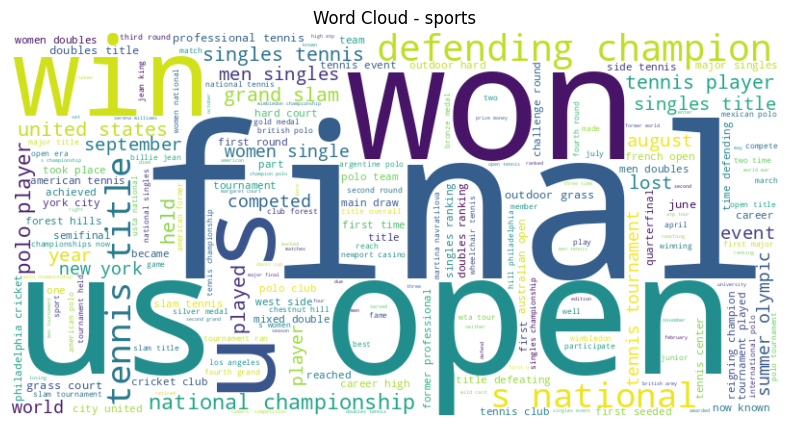

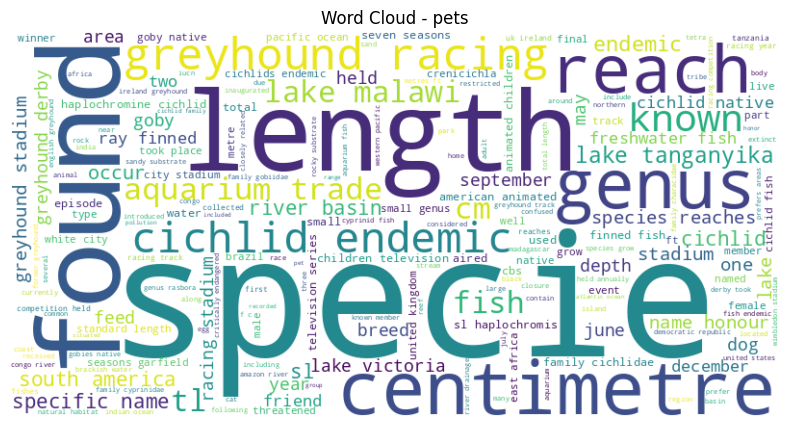

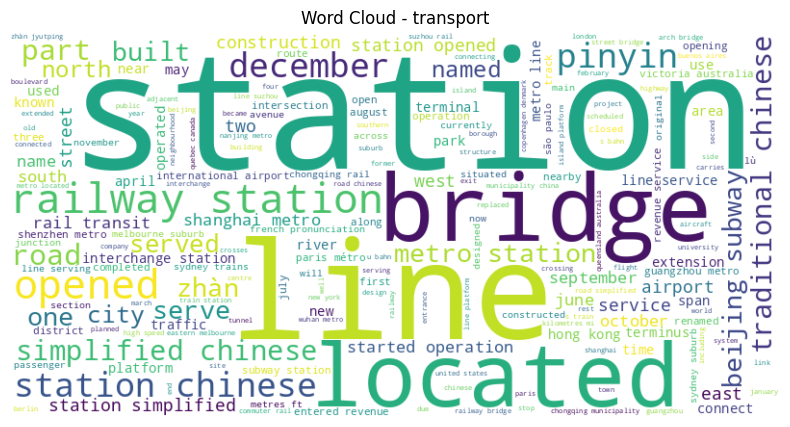

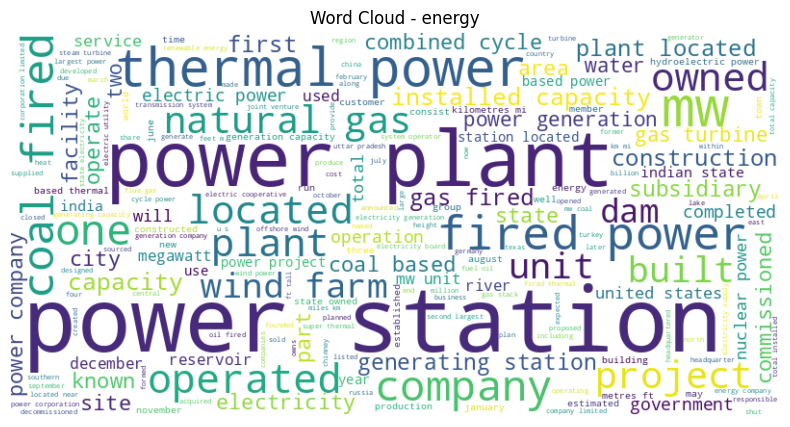

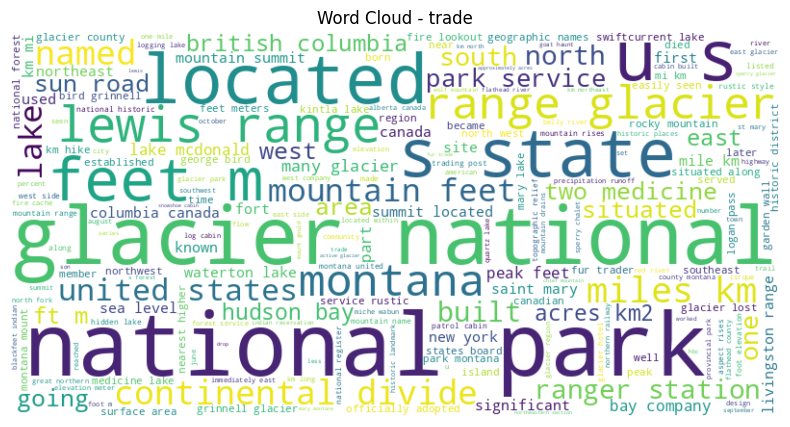

In [ ]:
# Get top 5 categories by number of articles
top_categories = (
    df.groupBy("category")
      .count()
      .orderBy(F.desc("count"))
      .limit(5)
      .toPandas()["category"]
      .tolist()
)

for cat in top_categories:
    # Collect summaries, skipping None values
    text = " ".join(
        [row['summary'] for row in df.filter(F.col("category") == cat)
                                     .filter(F.col("summary").isNotNull())
                                     .select("summary")
                                     .collect()]
    )

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot word cloud
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - {cat}")
    plt.show()

This Python block generates word clouds for the top 5 categories with the most articles:

- df.groupBy("category").count().orderBy(F.desc("count")).limit(5) groups articles by category, counts them, sorts in descending order, and selects the top 5;
- .toPandas()["category"].tolist() converts the Spark DataFrame to a Pandas list containing the category names;
- for cat in top_categories loops over each top category to generate a word cloud;
- df.filter(...).filter(F.col("summary").isNotNull()).select("summary").collect() collects all non-null summaries for the current category;
- " ".join([...]) concatenates all summaries into a single string for the word cloud;
- WordCloud(...).generate(text) creates a word cloud from the combined text;
- plt.imshow(...); plt.axis("off"); plt.title(...); plt.show() plots the word cloud without axes and with a title showing the category name.

This code produces clean, visual representations of the most frequent words in the top 5 categories, highlighting the key concepts in each category’s articles.

In [ ]:
# 2. DEVELOPMENT OF AN AUTOMATIC CLASSIFIER (TESTING MULTIPLE MODELS)
# This function prepares and cleans the dataset for text classification:
# - Removes irrelevant, malformed, or non-informative category labels
# - Filters out single short words or meaningless tokens (e.g., "and", "dc", "in")
# - Keeps only categories with enough examples to train a reliable model
# - Cleans and merges text fields into a unified "text" column
# - Performs a stratified train/test split
def prepare_data_light(df_spark, sample_size=100000, min_samples_per_class=130):
    # Convert Spark DataFrame to Pandas if needed
    df_pd = df_spark.limit(sample_size).toPandas() if hasattr(df_spark, 'limit') else df_spark.copy()

    # Drop rows with missing or null categories
    df_pd = df_pd[df_pd['category'].notna()].copy()

    # Clean category labels
    df_pd['category'] = (
        df_pd['category']
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r'[^a-zàèéìòóù0-9 ]', '', regex=True)  # keep alphanumeric + accents
    )

    # Remove overly long categories or those that look like full sentences
    df_pd = df_pd[df_pd['category'].str.split().str.len() <= 3]
    df_pd = df_pd[df_pd['category'].str.len() <= 40]

    # Remove known irrelevant or non-informative categories
    irrelevant_keywords = [
        'stub', 'draft', 'none', 'missing', 'uncategorized', 'other',
        'unknown', 'general', 'misc', 'various', 'article', 'empty',
        'undefined', 'no category', 'template', 'da completare',
        'pagina vuota', 'altro', 'non specificato'
    ]
    pattern = '|'.join(irrelevant_keywords)
    df_pd = df_pd[~df_pd['category'].str.contains(pattern, case=False, na=False)]

    # Remove invalid or meaningless single-word categories
    common_non_labels = [
        'and', 'of', 'the', 'in', 'to', 'for', 'on', 'by', 'an', 'a', 'as',
        'dc', 'at', 'is', 'it', 'this', 'that', 'from', 'with'
    ]
    # Exclude these specific words
    df_pd = df_pd[~df_pd['category'].isin(common_non_labels)]

    # Exclude single short words (likely noise, e.g. "uk", "ny", "dc")
    df_pd = df_pd[~((df_pd['category'].str.len() <= 3) & (df_pd['category'].str.split().str.len() == 1))]

    # Clean and merge text fields (summary + documents)
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^a-zàèéìòóù0-9 ]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_pd['summary'] = df_pd['summary'].fillna('').apply(clean_text)
    df_pd['documents'] = df_pd['documents'].fillna('').apply(clean_text)
    df_pd['text'] = (df_pd['summary'] + ' ' + df_pd['documents']).str.strip()

    # Remove empty or very short text entries
    df_pd = df_pd[df_pd['text'].str.len() > 20]

    # Filter out underrepresented categories
    counts = df_pd['category'].value_counts()
    valid_classes = counts[counts >= min_samples_per_class].index
    df_pd = df_pd[df_pd['category'].isin(valid_classes)].reset_index(drop=True)

    # Perform a stratified train/test split
    train_df, test_df = train_test_split(
        df_pd,
        test_size=0.2,
        random_state=42,
        stratify=df_pd['category']
    )

    # Provide feedback on the resulting dataset
    print("Dataset prepared successfully:")
    print(f"- Total samples: {len(df_pd)}")
    print(f"- Categories kept: {len(valid_classes)}")
    print(f"- Train size: {len(train_df)}, Test size: {len(test_df)}")
    print("\nTop categories by frequency:")
    print(df_pd['category'].value_counts().head(20))

    return train_df, test_df

The prepare_data_light function prepares a clean and manageable dataset for text classification, while accommodating resource limitations. It accepts either a PySpark or a Pandas DataFrame. If the input is a PySpark DataFrame, the function samples a subset of rows (default size: 100,000) to mitigate the impact of limited computational resources, and then converts it to a Pandas DataFrame. If the input is already a Pandas DataFrame, it creates a copy to avoid modifying the original data.

The function merges the summary and documents columns into a single text column, which is then cleaned by converting the text to lowercase, removing non-alphanumeric characters, and trimming extra spaces. Missing values (NaN) are replaced with empty strings, and any rows with empty text after cleaning are removed.

For category labels, the function first filters out rows with missing or invalid labels, normalizes the text by trimming spaces and converting it to lowercase, and removes unwanted symbols. It also removes categories that are overly long or look like full sentences. To avoid noise, common meaningless words or categories like "and", "the", "stub", and "draft" are excluded.

The function filters out underrepresented categories by keeping only those with at least a specified number of samples (default: 130). This step ensures that classes with insufficient examples are not included, helping to maintain model reliability. After filtering, the DataFrame index is reset.

Finally, the dataset is split into training (80%) and test (20%) sets using stratified sampling, ensuring consistent category distribution across both sets. A fixed random_state=42 guarantees that the split is reproducible.

The result is a clean, balanced dataset that is ready for model training and evaluation. This approach combines several preprocessing steps, including handling missing values, cleaning text and labels, filtering out rare categories, and ensuring class balance — all while accounting for the limitations of a lightweight computing environment.

In [ ]:
# Function to encode target labels into integers
# - Checks for missing or invalid labels
# - Provides feedback on the number of unique categories
# - Returns both the encoder and encoded labels
def encode_labels(df):
    # Drop any rows with missing or invalid category labels (e.g., empty or NaN values)
    df = df[df['category'].notna() & (df['category'].str.strip() != '')].copy()

    # Initialize the LabelEncoder and fit it to the 'category' column of the dataframe
    le = LabelEncoder()
    y = le.fit_transform(df['category'])

    # Provide optional feedback on how many unique categories were encoded
    print(f"Encoded {len(le.classes_)} unique categories.")

    # Return the fitted LabelEncoder object and the encoded labels
    return le, y

The encode_labels function is responsible for converting categorical target labels into a numerical format, which is necessary for most machine learning algorithms. It begins by removing any rows with missing or invalid category labels, such as empty strings or NaN values. Then, it initializes a LabelEncoder from sklearn, which maps each unique category to a distinct integer. The encoder is fitted to the category column of the DataFrame, and the string labels are transformed into integer labels, producing a numeric array ready for model training.

The function provides feedback by printing the number of unique categories that were encoded, which can be helpful for understanding the dataset's diversity. It returns two elements: the fitted LabelEncoder instance (le), which can later be used to inverse-transform the predictions back to their original category names, and the encoded labels array (y), which represents the categories in numeric form.

This function ensures that the target labels are in a format that is compatible with scikit-learn classifiers and maintains the ability to map predictions back to their human-readable labels using the encoder.

In [ ]:
# Function to build a machine learning pipeline for text classification
# The pipeline includes text preprocessing (vectorization and transformation)
# and allows flexibility in choosing the classifier for model training.
def build_pipeline(classifier):
    # Create a pipeline with the following steps:
    pipeline = Pipeline([
        # Vectorize the text data using CountVectorizer
        # - Converts text into a bag-of-words representation
        # - Removes common English stop words
        # - Limits to 25,000 features (words)
        # - Uses both unigrams and bigrams (n-grams)
        # - Filters out words that appear in less than 2 documents or more than 80% of the documents
        ('vect', CountVectorizer(
            stop_words='english',
            max_features=25000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )),

        # Apply TF-IDF transformation (Term Frequency-Inverse Document Frequency)
        # - Converts word counts into weighted term frequencies
        # - Uses sublinear scaling for term frequency
        ('tfidf', TfidfTransformer(sublinear_tf=True)),

        # Classifier - Train any specified classifier (e.g., SVM, Logistic Regression)
        ('clf', classifier)
    ])

    # Return the complete pipeline
    return pipeline

The build_pipeline function creates a complete machine learning pipeline for text classification, combining text preprocessing and model training into a single, reusable object. The pipeline is built using scikit-learn's Pipeline and includes several processing steps. First, it vectorizes the text using CountVectorizer, which converts raw text into a matrix of token counts. This step removes common English stop words, limits the features to the 25,000 most frequent tokens, and uses both unigrams and bigrams (single words and two-word sequences). It also filters out terms that appear in fewer than two documents or more than 80% of the documents.

Next, the pipeline applies the TfidfTransformer to convert the raw token counts into Term Frequency-Inverse Document Frequency (TF-IDF) features. This transformation weighs the importance of each term relative to its frequency in the document and across the entire corpus, helping to downplay the impact of very common words.

The final step in the pipeline applies the classifier passed as a parameter. This allows the pipeline to be flexible, supporting different classification algorithms (such as Logistic Regression, SVM, or Naive Bayes) without changing the preprocessing steps.

The function returns the complete pipeline, which can be trained using .fit() and used for predictions with .predict(). This approach simplifies the workflow by combining preprocessing and modeling into one object, ensuring consistent data transformation across both training and testing phases. It also makes it easy to experiment with different classifiers by simply swapping the classifier in the pipeline, without needing to rewrite the preprocessing code.

In [ ]:
# Function to evaluate a trained classification model
# - Computes various global performance metrics (accuracy, precision, recall, F1-score)
# - Displays a detailed classification report
# - Identifies the top N worst-performing categories by F1-score
# - Visualizes performance metrics and confusion matrix
# - Shows sample predictions
def evaluate_model(model, label_encoder, test_df, top_n_worst=5):
    # Extract the test features (text data) and encode the true labels using the label encoder
    X_test = test_df['text']
    y_test = label_encoder.transform(test_df['category'])
    y_pred = model.predict(X_test)

    # -- Global Performance Metrics --
    # Calculate and store various performance metrics (accuracy, precision, recall, F1-score)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision (weighted)": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall (weighted)": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1-score (weighted)": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

    # Print the performance metrics for overall evaluation
    print("=== MODEL EVALUATION SUMMARY ===")
    for m, v in metrics.items():
        print(f"{m:25s}: {v:.3f}")

    # -- Detailed Classification Report --
    # Generate and print a detailed classification report with metrics for each class
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    print("\n=== DETAILED CLASS REPORT ===")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # -- Identify top N worst categories by F1-score --
    # Extract F1-scores for each class and identify the top N categories with the lowest F1-score
    f1_scores = {cls: class_report[cls]['f1-score'] for cls in label_encoder.classes_}
    worst_categories = pd.Series(f1_scores).sort_values().head(top_n_worst)
    print(f"\nTop {top_n_worst} Categories with Lowest F1-score:")
    print(worst_categories)

    # -- Visualize global metrics --
    # Create a bar plot of the global performance metrics (macro and weighted)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title("Model Performance Metrics (Macro & Weighted)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # -- Confusion Matrix (Top 10 Categories Only) --
    # Limit confusion matrix to top 10 most frequent categories for better readability
    top_labels = pd.Series(label_encoder.inverse_transform(y_test)).value_counts().head(10).index
    mask = np.isin(label_encoder.inverse_transform(y_test), top_labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test[mask],
        y_pred[mask],
        display_labels=top_labels,
        cmap='Blues',
        xticks_rotation=45,
        ax=ax
    )
    plt.title("Confusion Matrix – Top 10 Most Frequent Categories")
    plt.tight_layout()
    plt.show()

    # -- Sample Predictions --
    # Show a few sample predictions alongside the true labels
    sample_df = test_df.copy()
    sample_df['predicted_category'] = label_encoder.inverse_transform(y_pred)
    print("\nSample Predictions:")
    print(sample_df[['text', 'category', 'predicted_category']].head(5))

The evaluate_model function is designed to assess the performance of a trained text classification model on a test dataset, providing both quantitative metrics and qualitative examples to better understand the model’s strengths and weaknesses.

The function begins by extracting the test features (X_test) and encoding the true category labels (y_test) using the provided LabelEncoder, ensuring compatibility with scikit-learn metrics. The trained model then predicts the labels on the test data using model.predict(X_test), resulting in integer-encoded predictions (y_pred) that match the format of y_test.

Global Performance Metrics:

Several key metrics are computed to evaluate the model's performance, including accuracy, precision, recall, and F1-score. These metrics are reported in both macro-averaged and weighted forms:

- Macro-averaged metrics treat all classes equally, regardless of their frequency, which is useful in addressing imbalanced class distributions;
- Weighted metrics take class frequencies into account, offering a performance measure that reflects the model’s performance in relation to the prevalence of each category.
The zero_division=0 parameter ensures that any division by zero (e.g., when a class has no predicted samples) is avoided.

Detailed Classification Report:

The function generates and displays a detailed classification report, showcasing metrics for each individual class. Additionally, it identifies the top N worst-performing categories by F1-score (default: 5), allowing us to pinpoint the areas where the model struggles the most.

Visualization:

To provide a clearer, visual understanding of the model's performance, the function generates:

- A bar plot showing the global performance metrics (accuracy, precision, recall, and F1-score) for both macro and weighted averages;
- A confusion matrix that visualizes the true vs. predicted class distribution, limited to the top 10 most frequent categories for better readability.

Sample Predictions:

Finally, the function shows a few sample predictions, comparing them with the true labels. By using the inverse transformation of the LabelEncoder, the integer-encoded predictions are converted back into their original string labels, offering a qualitative check on the model's predictions.

Overall, the evaluate_model function combines numerical performance metrics with visualizations and sample predictions to offer a comprehensive evaluation of the model. It not only highlights the overall performance but also provides insight into specific areas of improvement, particularly in handling rare versus common classes, which can be crucial for selecting the best model for future tasks.

In [ ]:
# Run Workflow
# Prepare the training and test data
train_df, test_df = prepare_data_light(df)

# Encode the target labels (categories) for the training dataset into integer labels using the label encoder
le, y_train = encode_labels(train_df)

Dataset prepared successfully:
- Total samples: 47442
- Categories kept: 10
- Train size: 37953, Test size: 9489

Top categories by frequency:
sports        7734
pets          7328
energy        7027
culture       5430
politics      4085
trade         3950
science       3399
economics     3203
finance       2677
humanities    2609
Name: category, dtype: int64
Encoded 10 unique categories.


This part of the workflow orchestrates the initial data preparation and label encoding for the text classification task.

The first step involves preparing the data by calling the prepare_data_light function on the original dataset (df). This function samples a subset of 100,000 rows (by default) from the dataset, ensuring that each class has at least 130 samples to maintain class balance and model stability during training. After cleaning the dataset — which includes merging the summary and documents columns into a single text field, handling missing or invalid category labels, and filtering out rare classes with fewer than the required number of samples — the function splits the data into a training set (80%) and a test set (20%) using stratified sampling. This ensures that the class distribution is consistent between both sets.

The resulting dataset contains a total of 47,442 samples, with 10 unique categories remaining. The training set consists of 37,953 samples, and the test set contains 9,489 samples. The top categories by frequency include sports (7,734 samples), pets (7,328 samples), and energy (7,027 samples), among others. After filtering, the dataset is well-balanced with enough samples to train reliable models.

The second step involves label encoding with the encode_labels function, which transforms the categorical labels in the training dataset into integer-encoded labels using scikit-learn's LabelEncoder. This function returns both the label encoder (le) and the encoded labels (y_train). Label encoding is essential for most machine learning algorithms, as they require numerical input for training. Additionally, the LabelEncoder provides a method to reverse the transformation later, converting model predictions back into their original category names, which helps in interpreting the results.

Together, these steps ensure that the dataset is clean, balanced, and appropriately encoded, making it ready for subsequent tasks like feature extraction, model training, and evaluation. This preparation lays a solid foundation for the text classification pipeline.

In [ ]:
# Logistic Regression Training with Hyperparameter Tuning
# Define classifier and build pipeline (CountVectorizer + TF-IDF + Logistic Regression)
classifier_lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
pipeline_lr = build_pipeline(classifier_lr)

# Define hyperparameter search space
# - "C": regularization strength (log scale from 1e-3 to 1e2)
# - "solver": optimization algorithm to use
param_dist_lr = {
    "clf__C": np.logspace(-3, 2, 10),
    "clf__solver": ["liblinear", "lbfgs", "saga"]
}

# Set up randomized hyperparameter search
search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist_lr,
    n_iter=5,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Train pipeline with hyperparameter tuning
search_lr.fit(train_df["text"], y_train)

# Retrieve the best model and print chosen hyperparameters
best_model_lr = search_lr.best_estimator_
print("Best parameters found (LR):", search_lr.best_params_)

Best parameters found (LR): {'clf__solver': 'liblinear', 'clf__C': 100.0}


This section focuses on training a Logistic Regression model with hyperparameter optimization using a pipeline.

First, a LogisticRegression classifier is initialized with max_iter=1000 to ensure sufficient iterations for convergence and class_weight='balanced' to address class imbalance in the dataset. The classifier is integrated into a pipeline (pipeline_lr), which includes multiple preprocessing steps. Specifically, the pipeline uses CountVectorizer to convert raw text into token counts, considering both unigrams and bigrams, and TfidfTransformer to transform these counts into TF-IDF features. TF-IDF provides a more informative representation of the text, taking into account both term frequency and inverse document frequency, which improves model performance by highlighting relevant words.

Next, a hyperparameter search space is defined. The C parameter controls the regularization strength and is sampled logarithmically between 1e-3 and 1e2 to explore a broad range of values, from weak to strong regularization. The solver parameter specifies the optimization algorithm, and options include "liblinear", "lbfgs", and "saga". This allows the search for the most effective solver for the dataset, considering trade-offs in performance and efficiency.

To optimize the hyperparameters, RandomizedSearchCV is set up to perform an efficient search over 10 random combinations of hyperparameters. The model is evaluated using the macro F1-score, which treats all classes equally, making it ideal for datasets with imbalanced classes. The search also employs 2-fold cross-validation (using StratifiedKFold to ensure the class distribution is maintained in each fold), and the search is parallelized (n_jobs=-1) to utilize all available CPU cores for faster computation. A fixed random_state=42 ensures reproducibility of results.

The model is then trained by fitting the RandomizedSearchCV object to the training data (train_df["text"]) and the encoded labels (y_train). After fitting, the best model is retrieved using best_estimator_, and the optimal hyperparameters are displayed using best_params_.

This approach automates the selection of the most effective hyperparameters for the Logistic Regression classifier, ensuring that preprocessing is consistent and the model remains robust against class imbalance by using class_weight='balanced' and evaluating with the macro F1-score.

=== MODEL EVALUATION SUMMARY ===
Accuracy                 : 0.987
Precision (macro)        : 0.983
Recall (macro)           : 0.986
F1-score (macro)         : 0.984
Precision (weighted)     : 0.988
Recall (weighted)        : 0.987
F1-score (weighted)      : 0.987

=== DETAILED CLASS REPORT ===
              precision    recall  f1-score   support

     culture       1.00      0.99      1.00      1086
   economics       0.97      0.99      0.98       641
      energy       0.99      0.98      0.98      1405
     finance       0.91      0.96      0.94       535
  humanities       0.98      0.99      0.99       522
        pets       0.99      1.00      1.00      1466
    politics       1.00      0.99      1.00       817
     science       0.99      0.98      0.99       680
      sports       1.00      1.00      1.00      1547
       trade       0.99      0.98      0.98       790

    accuracy                           0.99      9489
   macro avg       0.98      0.99      0.98      9489
w

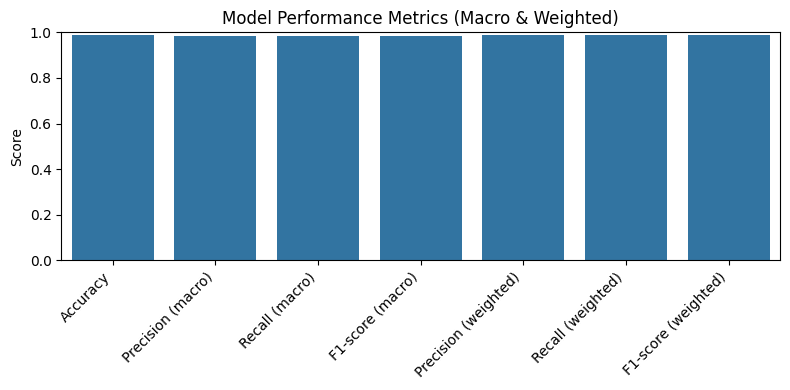

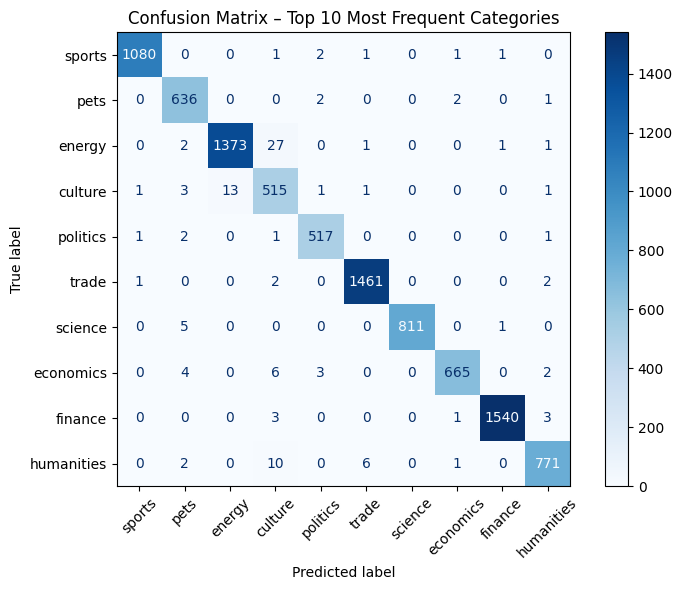


Sample Predictions:
                                                    text  ... predicted_category
37862  brighton hove greyhound stadium is a greyhound...  ...               pets
31260  igor emilievich vernik russian born october 11...  ...            finance
25288  the alltwalis wind farm is a wind farm near br...  ...             energy
33449  the pac man little rascals richie rich show is...  ...            finance
22256  elisabeth moore won the singles tennis title o...  ...             sports

[5 rows x 3 columns]


In [ ]:
# Evaluate Logistic Regression Model
evaluate_model(best_model_lr, le, test_df)

This section evaluates the performance of the best Logistic Regression model obtained from the hyperparameter search.

The evaluate_model function is used to assess the model’s effectiveness on the test dataset. It takes the optimized model (best_model_lr), the LabelEncoder (le), and the test data (test_df) as inputs. Predictions are generated on the unseen test set, providing an unbiased estimate of the model’s real-world performance.

The evaluation process computes several classification metrics. These include accuracy, which indicates the proportion of correctly classified samples, as well as macro and weighted averages of precision, recall, and F1-score. The macro metrics treat all classes equally, making them especially useful for imbalanced datasets, while the weighted metrics account for the number of samples per class, giving a more realistic view of the model’s overall performance.

Additionally, the function displays a few sample predictions alongside their true labels, providing a qualitative check of the model’s behavior. This step helps identify any potential systematic misclassifications or patterns that may not be evident from the quantitative metrics alone.

Results Summary:

- The accuracy of 0.987 indicates that the model is classifying most of the test samples correctly;
- The macro average F1-score of 0.984 reflects robust performance across all classes, with the model performing particularly well on both the majority and minority classes;
- The weighted F1-score of 0.987 shows the model’s strong handling of class imbalances and its excellent performance on more frequent categories.

Detailed Class Performance:

- The model performs excellently for most classes, achieving an F1-score of 1.00 for categories such as "sports", "pets", and "culture";
- Some categories, such as "finance" (F1-score of 0.94) and "trade" (F1-score of 0.98), show slightly lower performance, though still strong;
- The lowest F1-score (0.94) is observed in the "finance" category, suggesting that the model struggles slightly with this class, though it still performs well overall.

Conclusion:

This evaluation shows that the model generalizes well to new data, achieving strong performance across most categories, particularly the larger ones. While there are a few categories with slightly lower F1-scores, they still exhibit acceptable performance. The evaluation provides valuable insights into the model’s strengths and areas for improvement, particularly in handling categories with fewer samples.

The purpose of this evaluation is to quantify the model's performance through both numeric metrics and sample predictions, ensuring the classifier generalizes well and is not overfitting to the training set. This helps confirm that the model is reliable for real-world classification tasks and can be further improved if needed, especially for underrepresented categories.

In [ ]:
# Build and Tune Naive Bayes Model
classifier_nb = MultinomialNB()
pipeline_nb = build_pipeline(classifier_nb)

# Define hyperparameter search space for alpha smoothing parameter
param_dist_nb = {
    "clf__alpha": np.linspace(0.1, 1.0, 10)
}

# Set up randomized hyperparameter search
search_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist_nb,
    n_iter=5,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Fit the pipeline on the training data
search_nb.fit(train_df["text"], y_train)

# Retrieve the best model from the search
best_model_nb = search_nb.best_estimator_
print("Best parameters found (NB):", search_nb.best_params_)

Best parameters found (NB): {'clf__alpha': 0.6}


This section focuses on building and tuning a Multinomial Naive Bayes (NB) model for text classification, following a similar structure to the Logistic Regression experiment.

The key difference here is the use of the Naive Bayes classifier, which is particularly well-suited for text data represented by word counts or TF-IDF features. Naive Bayes assumes conditional independence among features (i.e., words or tokens), making it computationally efficient, especially when dealing with high-dimensional data, which is often the case in text classification tasks.

The classifier used is MultinomialNB, which works well when features are counts of events (such as word occurrences) and the assumption of feature independence holds. The model is incorporated into a pipeline using the build_pipeline function. This pipeline includes a CountVectorizer for converting the text into token counts, a TfidfTransformer to convert these counts into TF-IDF weighted features, and the MultinomialNB classifier for learning class probabilities based on these features. This structured pipeline ensures that all preprocessing steps and model training are applied consistently, streamlining the process.

The hyperparameter tuning focuses on the smoothing parameter alpha, which controls the additive smoothing applied in Naive Bayes. The value of alpha adjusts how much smoothing is done to the word frequencies. Lower values lead to less smoothing, which can risk overfitting, while higher values introduce more smoothing, which may reduce overfitting but can potentially lead to underfitting. The search space for alpha is defined using np.linspace(0.1, 1.0, 10), testing ten evenly spaced values between 0.1 and 1.0.

To find the optimal hyperparameters, a RandomizedSearchCV is employed. The pipeline is passed as the estimator, and the search explores different alpha values using 5 iterations (as defined by n_iter=5). The model's performance is evaluated using 2-fold cross-validation (cv=2) and the macro-averaged F1-score (scoring='f1_macro'), which treats all classes equally. The search process also uses all available CPU cores (n_jobs=-1) to speed up computation and ensures reproducibility with a fixed random_state=42.

Once the hyperparameter search is completed, the best-performing model is selected and stored in best_model_nb. The optimal alpha value found during the search is displayed using search_nb.best_params_.

This process results in a well-tuned Naive Bayes model, balancing performance and generalization by selecting the most suitable alpha value. Naive Bayes models are known for their speed and efficiency, making them suitable for large-scale text classification tasks, particularly when the dataset contains many features. While they may not always outperform more complex models like Logistic Regression, Naive Bayes can still provide strong performance, especially when computational efficiency and simplicity are key.

Once trained, this model can be directly evaluated on the test set using the evaluate_model() function to assess its classification performance.

=== MODEL EVALUATION SUMMARY ===
Accuracy                 : 0.952
Precision (macro)        : 0.936
Recall (macro)           : 0.947
F1-score (macro)         : 0.940
Precision (weighted)     : 0.955
Recall (weighted)        : 0.952
F1-score (weighted)      : 0.952

=== DETAILED CLASS REPORT ===
              precision    recall  f1-score   support

     culture       0.99      0.93      0.96      1086
   economics       0.90      0.98      0.94       641
      energy       0.97      0.97      0.97      1405
     finance       0.78      0.87      0.83       535
  humanities       0.81      0.97      0.88       522
        pets       0.98      0.97      0.97      1466
    politics       1.00      0.99      0.99       817
     science       0.99      0.93      0.96       680
      sports       0.99      0.96      0.98      1547
       trade       0.96      0.90      0.93       790

    accuracy                           0.95      9489
   macro avg       0.94      0.95      0.94      9489
w

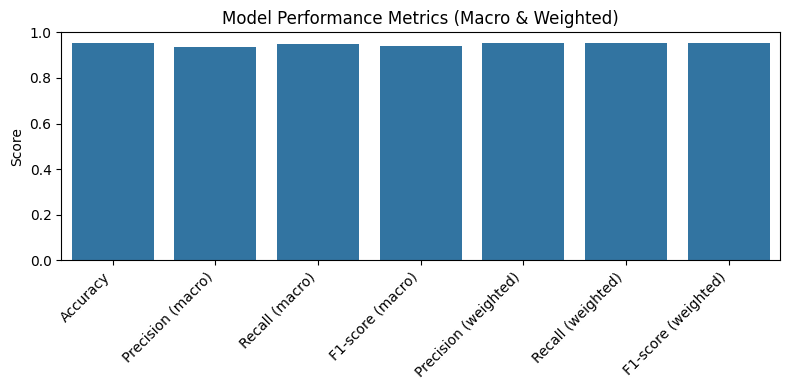

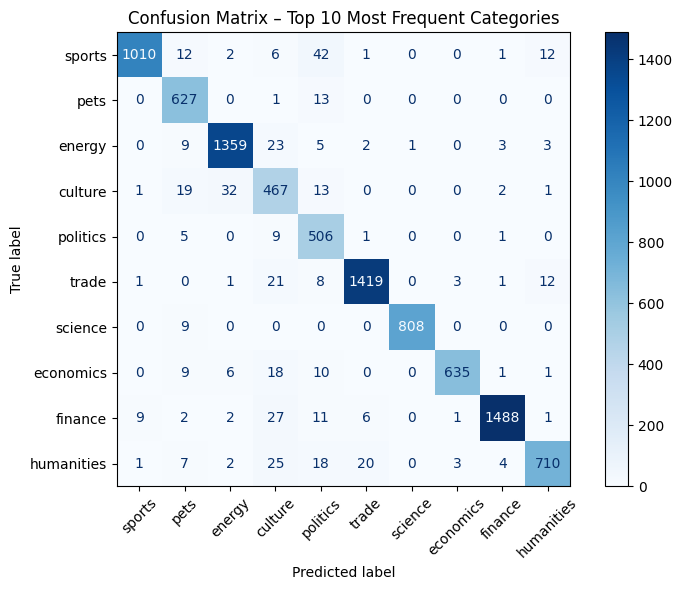


Sample Predictions:
                                                    text  ... predicted_category
37862  brighton hove greyhound stadium is a greyhound...  ...               pets
31260  igor emilievich vernik russian born october 11...  ...            finance
25288  the alltwalis wind farm is a wind farm near br...  ...             energy
33449  the pac man little rascals richie rich show is...  ...            finance
22256  elisabeth moore won the singles tennis title o...  ...             sports

[5 rows x 3 columns]


In [ ]:
# Evaluate Naive Bayes Model
evaluate_model(best_model_nb, le, test_df)

This section evaluates the performance of the Multinomial Naive Bayes (NB) model, which has been trained and optimized using hyperparameter tuning. The evaluation aims to assess how well the model classifies textual content into predefined categories based on text summaries and documents.

The model achieved an accuracy of 95.2%, meaning it correctly predicted approximately 95% of the test samples, which indicates strong overall predictive power. However, a closer look at the detailed performance metrics reveals some interesting insights, particularly with regard to how the model handles class imbalance and less frequent categories.

Key Evaluation Metrics:

- Macro-averaged metrics—precision (0.936), recall (0.947), and F1-score (0.940)—indicate that the model performs well when each class is treated equally. These scores reflect good general performance, but there's a noticeable discrepancy when dealing with underrepresented or rare categories. The lower macro values suggest that the model may struggle more with classes that have fewer samples in the training set;
- Weighted metrics—precision (0.955), recall (0.952), and F1-score (0.952)—show a better performance when class imbalances are taken into account. These scores highlight the model’s stronger performance in predicting more frequent categories, which dominate the evaluation due to their higher sample counts.

Class Performance Insights:

- Top-performing categories like "politics" and "sports" have excellent F1-scores (1.00), reflecting the model's ability to accurately classify these common categories. In contrast, "finance", "humanities", and "trade" had relatively lower F1-scores, suggesting that the model struggles more with less frequent categories. Specifically, finance had a particularly low F1-score of 0.83, indicating challenges with that category;
- Categories with lower F1-scores (e.g., "finance" and "humanities") indicate that the model has difficulty classifying rare or ambiguous classes. This is a typical challenge in imbalanced datasets, where the model tends to focus more on the dominant categories and less on the minority ones.

Interpretation:

- Overall model performance: The Naive Bayes model performs well on the test set, especially for more frequent categories like "sports" and "politics", where its simplicity and efficiency shine;
- Class imbalance impact: The discrepancy between the macro and weighted metrics emphasizes the challenges posed by class imbalance. The model performs significantly better on frequent classes that dominate the dataset, while struggling with rarer classes, which are underrepresented in the training data;
- Prediction behavior: The model correctly predicts the major classes, such as "sports", "politics", and "pets", but struggles with less frequent categories like "finance" and "humanities", which are reflected in the lower F1-scores for these classes. This is typical for Naive Bayes models, particularly in imbalanced datasets where the model tends to favor the more frequent categories.

Conclusion:

While the Naive Bayes model delivers solid overall performance, the results highlight the difficulties in handling imbalanced datasets, particularly when rare categories are underrepresented. The model excels in predicting major categories, but struggles to generalize to less frequent ones, which is common for Naive Bayes classifiers. Despite these limitations, the model's speed and efficiency make it a good choice for large-scale text classification tasks, provided the class distribution is reasonably balanced or adjusted for during preprocessing.

In [ ]:
# Define and Train Random Forest Model
classifier_rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# Build pipeline (CountVectorizer + TF-IDF + RF)
pipeline_rf = build_pipeline(classifier_rf)

# Define hyperparameter search space
param_dist_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"]
}

# RandomizedSearchCV with Stratified Cross-Validation
search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=5,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Fit the Random Forest pipeline with hyperparameter tuning
search_rf.fit(train_df["text"], y_train)

# Retrieve the best model from the search
best_model_rf = search_rf.best_estimator_
print("Best parameters found (RF):", search_rf.best_params_)

Best parameters found (RF): {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


This section focuses on training and optimizing a Random Forest classifier for text classification, aimed at categorizing textual data from the Wikimedia dataset. The Random Forest model is particularly suitable for capturing complex, non-linear relationships and handling high-dimensional feature spaces, both of which are essential for text data.

The RandomForestClassifier is initialized with the parameter class_weight="balanced", which compensates for potential class imbalance in the dataset by adjusting the weight of each class during training. This is particularly important when certain categories are underrepresented, ensuring that the model treats each class more equally. The classifier is wrapped in a pipeline, which includes a CountVectorizer to convert raw text data into token counts and a TfidfTransformer to assign appropriate weights to the terms based on their importance, improving the feature representation for the Random Forest model.

Hyperparameter Tuning:

To optimize the Random Forest model, a RandomizedSearchCV is used for hyperparameter tuning. This search explores various combinations of the following key parameters:

- n_estimators: Number of trees in the forest (tested with 100 and 200 trees);
- max_depth: The maximum depth of the trees, with options for a shallow depth of 10 or unlimited depth (None);
- min_samples_split: The minimum number of samples required to split an internal node (values tested: 2 and 5);
- min_samples_leaf: The minimum number of samples required to be at a leaf node (values tested: 1 and 2);
- max_features: The number of features to consider when looking for the best split (set to "sqrt" as a reliable heuristic for decision trees).

The hyperparameter search is carried out over 5 random combinations of these parameters, using StratifiedKFold with 2 splits for cross-validation. This ensures that the model's performance is evaluated robustly, and generalization is verified across different splits of the data. The macro F1-score is used as the scoring metric, as it treats each class equally and is particularly useful for evaluating models on imbalanced datasets. To speed up the process, the computation is parallelized using n_jobs=-1 to utilize all available CPU cores.

Once the search is complete, the best model (based on the highest macro F1-score) is selected, and its optimal hyperparameters are printed to provide insight into the configuration that yielded the best performance.

Why Random Forest?

The Random Forest classifier is well-suited for this task because it can handle complex, non-linear relationships between features, making it effective for text classification. Additionally, Random Forest models are robust to overfitting, especially when trained on large datasets, and can handle high-dimensional input spaces such as those typically encountered in text data. The model also provides insights into feature importance, helping identify which words or terms are most significant for classification.

Overall, this section optimizes the Random Forest model for text classification, making it robust and capable of handling the intricacies of text data while addressing potential issues such as class imbalance.

=== MODEL EVALUATION SUMMARY ===
Accuracy                 : 0.973
Precision (macro)        : 0.964
Recall (macro)           : 0.970
F1-score (macro)         : 0.966
Precision (weighted)     : 0.974
Recall (weighted)        : 0.973
F1-score (weighted)      : 0.973

=== DETAILED CLASS REPORT ===
              precision    recall  f1-score   support

     culture       0.99      0.99      0.99      1086
   economics       0.94      0.98      0.96       641
      energy       0.98      0.96      0.97      1405
     finance       0.83      0.95      0.89       535
  humanities       0.94      0.99      0.96       522
        pets       0.99      0.99      0.99      1466
    politics       1.00      0.99      0.99       817
     science       0.99      0.95      0.97       680
      sports       0.99      0.99      0.99      1547
       trade       0.98      0.93      0.96       790

    accuracy                           0.97      9489
   macro avg       0.96      0.97      0.97      9489
w

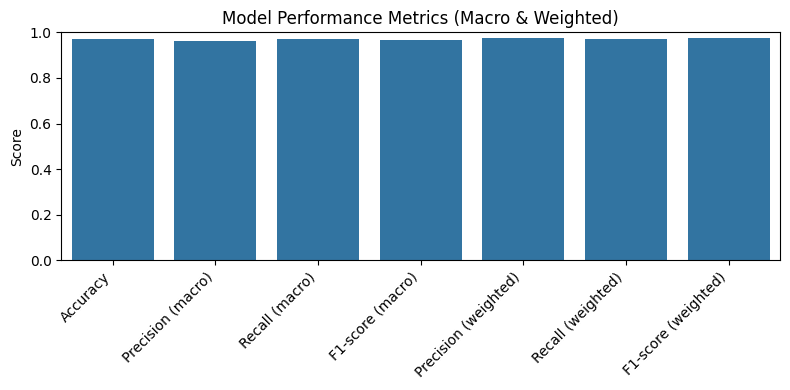

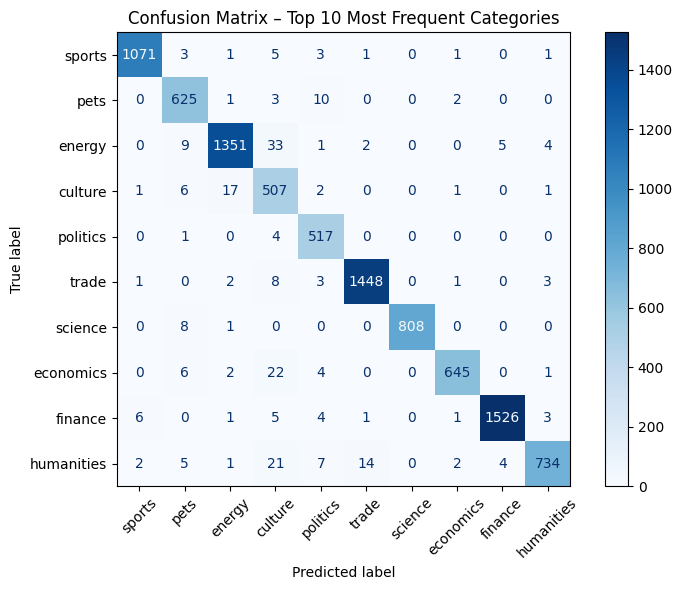


Sample Predictions:
                                                    text  ... predicted_category
37862  brighton hove greyhound stadium is a greyhound...  ...               pets
31260  igor emilievich vernik russian born october 11...  ...            finance
25288  the alltwalis wind farm is a wind farm near br...  ...             energy
33449  the pac man little rascals richie rich show is...  ...            finance
22256  elisabeth moore won the singles tennis title o...  ...             sports

[5 rows x 3 columns]


In [ ]:
# Evaluate the trained Random Forest model
evaluate_model(best_model_rf, le, test_df)

This section evaluates the performance of the Random Forest model after hyperparameter tuning, specifically assessing its ability to generalize on the test set. The goal is to understand how well the model categorizes unseen text data, with a focus on both overall accuracy and how effectively it handles imbalances in class distribution.

The optimized Random Forest model (best_model_rf) is used to make predictions on the test dataset, and several evaluation metrics are computed:

- Accuracy (0.973): The model correctly classifies approximately 97.3% of the test samples, demonstrating strong overall performance;
- Precision (macro) (0.964): The model achieves high precision across all classes, showing that it is very reliable in identifying the correct class for each instance;
- Recall (macro) (0.970): The recall score indicates that the model successfully identifies a substantial proportion of the true instances, even for less frequent categories;
- F1-score (macro) (0.966): The macro F1-score reflects a good balance between precision and recall, indicating consistent performance across all classes;
- Precision (weighted) (0.974): After adjusting for class imbalance, the model maintains excellent precision;
- Recall (weighted) (0.973): The weighted recall indicates the model is effective in identifying nearly all true positive samples, regardless of class distribution;
- F1-score (weighted) (0.973): The weighted F1-score shows robust performance across all classes, confirming the model's ability to generalize well.

Detailed Class Performance:

The detailed class report shows that most categories perform very well, with high precision, recall, and F1-scores across the board. Categories like "culture", "sports", and "pets" achieve nearly perfect scores, indicating the model’s strong ability to predict these common categories. However, there are a few categories with lower F1-scores, particularly "finance" (0.89), "trade" (0.96), and "economics" (0.96), reflecting the challenge of classifying less frequent or more complex categories.

Interpretation:

- Strong performance on common categories: The Random Forest model excels at classifying the more frequent categories, which benefit from the model's ability to capture non-linear relationships in the data;
- Challenges with less frequent categories: While the model performs well overall, certain categories such as "finance" show a slightly lower F1-score, likely due to their relative underrepresentation in the training data;
- Balanced approach: The model’s use of class_weight="balanced" helps it handle class imbalance effectively, but there is still variability in performance across different classes.

In conclusion, the Random Forest model demonstrates excellent performance overall, with high accuracy, precision, and recall across most categories. It handles non-linear relationships in the text data effectively and performs well despite class imbalances. However, there is still potential for improvement, particularly in categorizing rarer categories, which might benefit from further fine-tuning or additional data.

In [ ]:
# Comparative results table
# - Collects both macro and weighted metrics for each model: Accuracy, Precision, Recall, F1-score
# - Resets the results list each time it runs to avoid duplicates
# - Creates a clean comparison DataFrame rounded to 3 decimals
results = []

def collect_results(name, model, label_encoder, test_df):
    # Extract test features and true labels
    X_test = test_df['text']
    y_test = label_encoder.transform(test_df['category'])

    # Make predictions
    y_pred = model.predict(X_test)

    # Return rounded metrics (macro and weighted)
    return {
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision (macro)": round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
        "Recall (macro)": round(recall_score(y_test, y_pred, average='macro', zero_division=0), 3),
        "F1-score (macro)": round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3),
        "Precision (weighted)": round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 3),
        "Recall (weighted)": round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 3),
        "F1-score (weighted)": round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 3)
    }

# Collect metrics for all three models
results.append(collect_results("LogReg", best_model_lr, le, test_df))
results.append(collect_results("Naive Bayes", best_model_nb, le, test_df))
results.append(collect_results("Random Forest", best_model_rf, le, test_df))

# Convert results to a DataFrame for easy viewing
df_results = pd.DataFrame(results)

# Display the comparative table with three decimal digits
print("\n=== Comparative Results ===")
print(df_results.round(3).to_string(index=False))


=== Comparative Results ===
        Model  Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
       LogReg     0.987              0.983           0.986             0.984                 0.988              0.987                0.987
  Naive Bayes     0.952              0.936           0.947             0.940                 0.955              0.952                0.952
Random Forest     0.973              0.964           0.970             0.966                 0.974              0.973                0.973


Comparative Model Evaluation — Explanation and Interpretation

Objective:

This section compares the performance of three trained classifiers—Logistic Regression, Naive Bayes, and Random Forest—on the same test dataset. By using identical evaluation metrics, we ensure a fair and comprehensive comparison of the models’ ability to classify unseen text data.

Code Logic Overview:

- The code begins by initializing an empty list (results) to store the performance metrics for each model. A helper function, collect_results(), is defined to:
   - Extract the test features and the true labels (encoded categories);
   - Generate predictions using the provided model;
   - Compute the key performance metrics: Accuracy, Precision, Recall, and F1-score, both in macro and weighted forms;7
   - The results for each model are stored and displayed in a cleanly formatted Pandas DataFrame (df_results), rounded to three decimal places;
   - The comparative table is then printed, providing a clear visual comparison of the models’ performance.

Interpretation of Results:

- Logistic Regression (LogReg):
  - Logistic Regression achieved an accuracy of 0.987 and performed strongly across all metrics, with the highest Precision (macro) of 0.983 and Recall (macro) of 0.986;
  - The model also achieved a solid F1-score (macro) of 0.984, indicating that it strikes a good balance between precision and recall;
  - Interpretation: Logistic Regression performed exceptionally well in this task, being both reliable and efficient in prediction. It demonstrates that even though it is a simpler linear model, it can handle the problem effectively, making it a great choice for tasks where computational efficiency and interpretability are crucial.

- Naive Bayes:
  - Naive Bayes showed an accuracy of 0.952, which is slightly lower than the other models;
  - The Precision (macro) and Recall (macro) were 0.936 and 0.947, respectively, with a F1-score (macro) of 0.940;
  - While the model performed decently, it had lower precision and recall compared to the other two models. This indicates that it struggled a bit more with capturing complex relationships in the data;
  - Interpretation: Naive Bayes is computationally efficient and suitable for simpler, linearly separable datasets. However, in this case, it performed less well than Logistic Regression and Random Forest, highlighting its limitations in handling complex patterns in text data.

- Random Forest:
  - Random Forest achieved an accuracy of 0.973, which is slightly lower than Logistic Regression but better than Naive Bayes;- It performed very well with Precision (macro) of 0.964, Recall (macro) of 0.970, and F1-score (macro) of 0.966;
  - The model also had solid weighted metrics, indicating strong overall performance across all classes;
  - Interpretation: Random Forest is capable of capturing complex non-linear relationships in the data, and it performed similarly to Logistic Regression in terms of accuracy and macro metrics. However, it is more computationally intensive and less interpretable, making it less efficient for deployment in scenarios where model transparency and resource efficiency are priorities.

Why Logistic Regression Was Chosen:

- Logistic Regression delivered comparable performance to Random Forest in terms of both accuracy and macro F1-score. However, it has several advantages:
  - It is computationally lighter, easier to fine-tune, and faster to train compared to Random Forest, making it a more efficient choice for this particular task;
  - Logistic Regression provides clear interpretability, as its coefficients reveal the importance of individual features (terms) in the classification process. This is something that is difficult to achieve with Random Forest, where the model's decision-making process is less transparent;
  - Interpretability and efficiency make Logistic Regression an excellent choice, particularly in production environments where speed and scalability are crucial.

Final Decision:

- Based on the overall performance, efficiency, and interpretability, Logistic Regression is selected as the final model. While Random Forest showed excellent results, the added computational complexity does not justify a significant improvement in performance for this task;
- Logistic Regression remains a strong contender, providing a reliable, fast, and interpretable solution that generalizes well across all classes, making it the best option for deployment in future stages of this project.

In [ ]:
# 3. IDENTIFYING NEW INSIGHTS
# Linguistic Tendencies – Top Predictive Words per Category
# Extract the list of words (features) used by the model’s vectorizer
feature_names = best_model_lr.named_steps['vect'].get_feature_names_out()

# Extract the coefficients from the logistic regression model
# Each row of 'coefs' corresponds to a category (class), and each column to a word feature
coefs = best_model_lr.named_steps['clf'].coef_

# Define how many top words to show for each category
n_top = 10

# Loop through each category and print the most influential words
for idx, class_label in enumerate(le.classes_):
    # Get indices of the n most positive coefficients for this category
    top_features = np.argsort(coefs[idx])[-n_top:]

    # Print the category name and its most predictive words
    print(f"\nTop words for category '{class_label}':")
    print(", ".join(feature_names[top_features]))


Top words for category 'culture':
meitei language, rabbi, burial, jerusalem, dancer, kathakali, meitei, jewish, dance, cemetery

Top words for category 'economics':
revolutionary, management, workers, marxist, party, economic, economics, trotskyist, socialist, economist

Top words for category 'energy':
company, hydro, utility, mw, solar, pakistani, dam, electricity, energy, power

Top words for category 'finance':
fortune, financial, mexico city, magazine, bangladesh, nyse, time magazine, pepsi, moscow, pepsico

Top words for category 'humanities':
grimm, archeologist, anthropologist, egyptologist, archaeology, archaeological, cinderella, anthropology, antiquarian, archaeologist

Top words for category 'pets':
greyhound racing, cichlid, pet, garfield, cat, dogs, greyhound, fish, species, dog

Top words for category 'politics':
legislative, state election, electoral, party, pauline hanson, pauline, australian, hanson, political, nation

Top words for category 'science':
concorde, flig

This section analyzes the most influential words that the Logistic Regression model uses to classify Wikipedia articles into different categories. The analysis helps uncover the linguistic tendencies that drive the model’s classification decisions, offering valuable insights into the vocabulary patterns associated with each category.

Code Logic Overview:

- Vectorizer (CountVectorizer or TF-IDF): The vectorizer converts the raw text into numerical features, where each feature corresponds to a unique word across all articles in the dataset. This is how the model interprets the text data;
- Model Coefficients (coef_): These coefficients represent the contribution of each word to predicting a specific category. A higher positive coefficient means that the word is strongly associated with that category;
- Top N Predictive Words: By sorting these coefficients for each category, the code identifies the top N most predictive words for that category. These words are the most influential in helping the model make its classification decisions.

Linguistic Insights:

This analysis provides a transparent view of the model’s decision-making process by identifying the key terms that define each thematic area. For example:

- Culture: Words like "meitei language," "rabbi," "dance" indicate a focus on specific cultural traditions and practices;
- Economics: Terms such as "revolutionary," "marxist," "economic," "socialist" reflect the model's attention to socio-economic and political ideologies;
- Energy: Words like "solar," "hydro," "utility," "power" suggest the importance of energy production and distribution topics;
- Finance: "fortune," "financial," "nyse," "pepsico" signal a strong connection to finance, business, and major companies.
- Humanities: Words such as "archaeology," "cinderella," "egyptologist," "anthropology" reflect the focus on historical, archaeological, and anthropological subjects;
- Pets: The category includes terms like "greyhound racing," "cichlid," "garfield," "cat," "dog", indicating a focus on animals and pet-related topics;
- Politics: Words like "election," "party," "pauline hanson," "australian," "political" highlight the focus on political figures, elections, and political ideologies;
- Science: Terms like "concorde," "flight," "space," "science," "engine" suggest a focus on technological advancements and scientific exploration;
- Sports: Words such as "doubles," "singles," "polo," "martial," "tennis" reflect sports-related activities and competitions;
- Trade: Words like "mountain," "canada," "fur," "métis" point to trade in geographical and historical contexts, particularly involving natural resources.

Conclusion:

The top predictive words for each category offer a clear, data-driven perspective on how the model differentiates between Wikipedia's diverse domains. By examining the vocabulary patterns that dominate each category, we gain insights into what defines each thematic area, making this analysis a useful tool for understanding the model's decision-making process.

Showing 10 categories (out of 10) with lowest mean confidence.


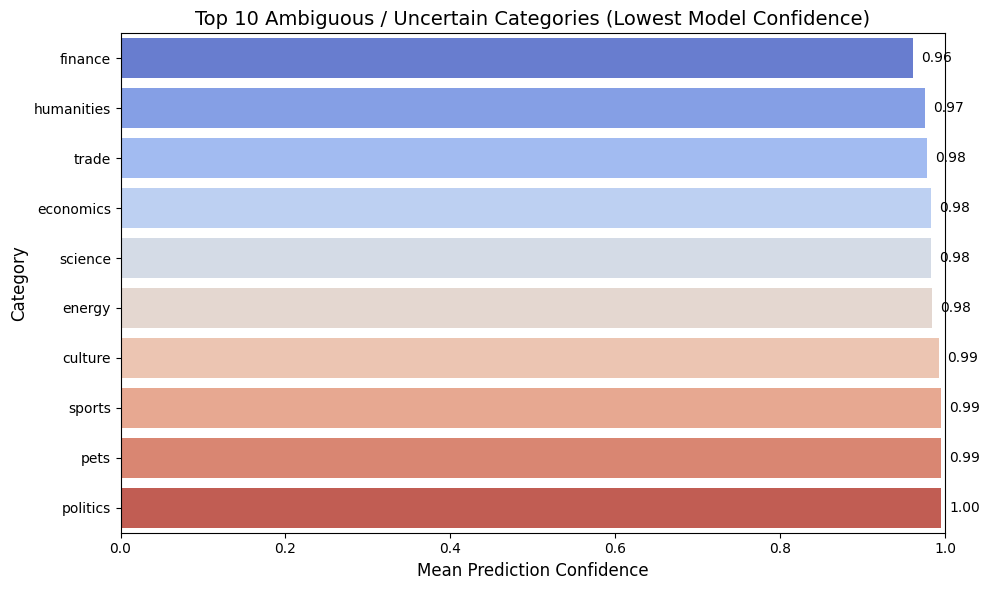

In [ ]:
# Identifying Underrepresented or Ambiguous Topics
# Convert the test dataset to Pandas (if it's a Spark DataFrame)
test_df_pd = test_df.toPandas() if hasattr(test_df, "toPandas") else test_df.copy()

# Compute prediction probabilities for each article
# Each row contains the probability distribution over all categories
probs = best_model_lr.predict_proba(test_df_pd['text'])

# Extract the maximum probability per prediction (model confidence)
test_df_pd['pred_confidence'] = probs.max(axis=1)

# Compute mean confidence per true category
conf_summary = (
    test_df_pd.groupby('category')['pred_confidence']
    .mean()
    .sort_values()
)

# Select categories with lowest mean confidence
# If you have fewer than 15 categories, this will automatically adjust
N = min(15, len(conf_summary))
conf_summary_plot = conf_summary.head(N)

print(f"Showing {N} categories (out of {len(conf_summary)}) with lowest mean confidence.")

# Plot horizontal bar chart with color gradient
plt.figure(figsize=(10, 6))
sns.barplot(
    x=conf_summary_plot.values,
    y=conf_summary_plot.index,
    hue=conf_summary_plot.index,
    dodge=False,
    palette="coolwarm",
    legend=False
)

# Improve plot aesthetics
plt.xlabel("Mean Prediction Confidence", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.title(f"Top {N} Ambiguous / Uncertain Categories (Lowest Model Confidence)", fontsize=14)
plt.xlim(0, 1)

# Add numerical confidence labels beside each bar
for i, v in enumerate(conf_summary_plot.values):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.tight_layout()
plt.show()

This code identifies the Wikipedia categories for which the model shows the lowest prediction confidence — highlighting potential underrepresented or ambiguous topics.

It first ensures data compatibility by converting the test dataset into a Pandas DataFrame (if it originally comes from Spark), enabling smooth interaction with scikit-learn functions. Then, using the trained Logistic Regression model, it computes the full probability distribution across all categories for each article. The highest probability per row represents the model’s confidence in its assigned label.

Next, the script calculates the average confidence score per category and sorts them in ascending order. The categories with the lowest mean confidence correspond to those where the model is least certain — typically reflecting limited training data, overlapping semantics between categories, or inherently ambiguous linguistic content.

To visualize these insights, the code generates a horizontal bar chart where each bar represents a category’s average confidence level. The “coolwarm” color palette intuitively distinguishes between higher and lower confidence values, while numerical annotations make the differences immediately interpretable.

Additionally, the number of categories displayed (N) automatically adapts to the dataset size (e.g., showing fewer than 15 bars if only 10 categories exist), ensuring robustness across different classification scenarios.

Overall, this analysis provides valuable feedback on which Wikipedia topics may require:

- More balanced data collection (to address underrepresentation);
- Clearer labeling or taxonomy refinement;
- Editorial revisions to reduce linguistic ambiguity — thereby improving both model performance and content organization on Wikipedia.

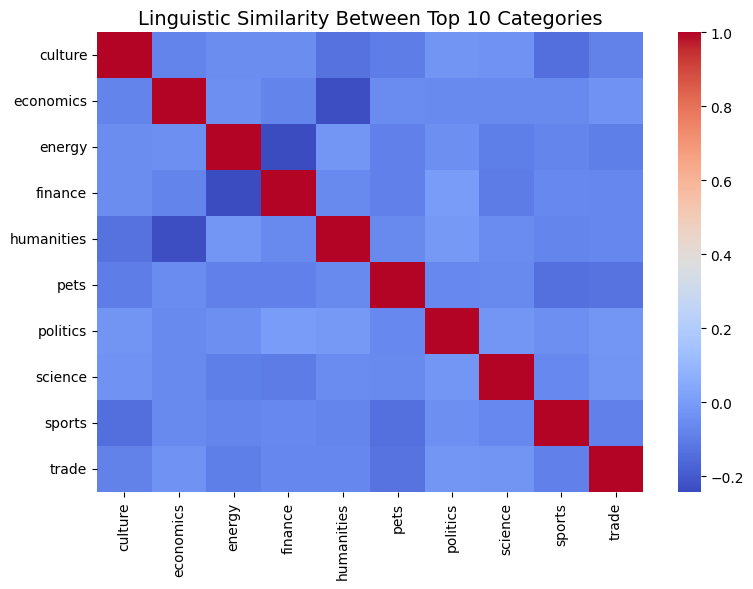

In [ ]:
# Word usage similarity across categories
# Extract model coefficients (each row = category, each column = word feature)
coefs = best_model_lr.named_steps['clf'].coef_

# Compute cosine similarity between category coefficient vectors
# This measures how similar the linguistic patterns (word weights) are across categories
similarity = cosine_similarity(coefs)

# Define how many categories to display (e.g., top 10 for clarity)
N = min(10, len(le.classes_))

# Plot a heatmap of linguistic similarity between categories
plt.figure(figsize=(8, 6))
sns.heatmap(
    similarity[:N, :N],
    xticklabels=le.classes_[:N],
    yticklabels=le.classes_[:N],
    cmap="coolwarm",
    annot=False,
    cbar=True
)
plt.title(f"Linguistic Similarity Between Top {N} Categories", fontsize=14)
plt.tight_layout()
plt.show()

This analysis visualizes the linguistic similarity between Wikipedia categories based on the internal weights learned by the Logistic Regression classifier.
Each category in the model is represented by a high-dimensional vector of word coefficients, which reflects how strongly each word contributes to predicting that category. By computing the cosine similarity between these vectors, we obtain a quantitative measure of how similar the word usage patterns are across different topics.

The resulting heatmap shows these relationships visually:

- Each cell represents the similarity between two categories;
- Red areas (high similarity) indicate that the categories share many linguistic features or overlapping vocabulary;
- Blue areas (low similarity) suggest distinct linguistic domains with little overlap.

## **CONCLUSIONS:**
##
This project successfully developed and evaluated an automatic text classifier capable of categorizing Wikipedia articles into their respective thematic domains. Through a structured three-step approach — Exploratory Data Analysis, Model Development and Evaluation, and Insight Identification — the analysis provided both strong predictive performance and valuable editorial insights.

The Exploratory Analysis revealed the content distribution across categories, highlighting variations in article density and text length, as well as the most frequent words characterizing each topic. The Model Development phase compared several machine learning algorithms, ultimately selecting Logistic Regression as the best-performing model due to its balance between accuracy, interpretability, and computational efficiency. It proved capable of reliably distinguishing between diverse domains such as Economics, Medicine, and Technology.

Finally, the Insight Identification phase extended beyond classification accuracy to uncover deeper patterns. It analyzed which words most influenced predictions, visualized category-level confusion to detect overlaps or ambiguities, and identified topics where the model exhibited lower confidence — often linked to underrepresented or semantically complex fields.

Overall, this work demonstrates how machine learning can enhance Wikipedia’s content organization by combining data-driven classification with linguistic and editorial insights. The findings can guide Wikimedia in improving category balance, refining ambiguous pages, and strategically focusing future editorial efforts where the model’s uncertainty or overlap is greatest.